# Analyzing Organ-Specific Age Gaps

## Overview

This notebook performs **comprehensive analysis of organ age gaps**, identifying patterns of accelerated and decelerated aging across different organ systems.

### Scientific Background

**Age gap (Δage)** is the difference between biological and chronological age:

$$\Delta \text{age} = \text{age}_{\text{biological}} - \text{age}_{\text{chronological}}$$

- **Positive gap (+)**: Organ is biologically older than expected (accelerated aging)
- **Negative gap (-)**: Organ is biologically younger than expected (decelerated aging)
- **Zero gap (0)**: Organ aging matches chronological age

### Clinical Relevance

Age gaps can indicate:
- **Disease risk**: Accelerated organ aging precedes clinical symptoms
- **Health interventions**: Target organs with largest positive gaps
- **Lifestyle factors**: Diet, exercise, stress affect specific organs
- **Personalized medicine**: Individual-specific aging profiles

### Objectives

1. Load trained models and test data
2. Compute biological ages for all organs
3. Calculate age gaps
4. Analyze age gap distributions
5. Examine correlations between organs
6. Stratify by demographics (sex, age groups)
7. Identify individuals with extreme aging patterns
8. Save age gap dataset

---

## 1. Setup and Imports

In [1]:
# Setup paths - works regardless of kernel working directory
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Get the notebook's directory and project root
try:
    # When running in Jupyter, __file__ doesn't exist, use a workaround
    notebook_path = Path().resolve()
    if notebook_path.name == 'notebooks':
        project_root = notebook_path.parent
    else:
        # Assume we're in the notebooks directory
        project_root = notebook_path.parent if (notebook_path.parent / 'src').exists() else notebook_path
except:
    project_root = Path().resolve().parent

# Add src to path if not already there
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print(f"✓ Project root: {project_root}")
print(f"✓ Source path: {src_path}")

# Data manipulation
import pandas as pd
import numpy as np
import json

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

# Project modules
from organ_aging import config
from organ_aging import models
from organ_aging import evaluation
from organ_aging import analysis
from organ_aging import visualization

print("✓ All imports successful")

✓ Project root: C:\Users\bastien\Documents\TAF\Hackathon\Vitalist
✓ Source path: C:\Users\bastien\Documents\TAF\Hackathon\Vitalist\src
✓ All imports successful


## 2. Load Trained Models and Test Data

In [2]:
# Load metadata
metadata_path = project_root / "data" / "processed" / "metadata.json"
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print(f"✓ Metadata loaded for {len(metadata)} organs")

# Load test datasets
organ_test_data = {}
for organ_name in metadata.keys():
    test_path = project_root / "data" / "processed" / organ_name / "test.parquet"
    test_df = pd.read_parquet(test_path)
    
    organ_test_data[organ_name] = {
        'X': test_df.drop(columns=['AGE']),
        'y': test_df['AGE']
    }

print(f"✓ Test data loaded for {len(organ_test_data)} organs")

# Load trained models (using best model: gradient boosting)
organ_models = {}
for organ_name in metadata.keys():
    model_path = project_root / "models" / organ_name / "hist_gb_model.pkl"
    organ_models[organ_name] = models.load_model(str(model_path))

print(f"✓ Models loaded for {len(organ_models)} organs")

✓ Metadata loaded for 5 organs
✓ Test data loaded for 5 organs
Loaded model with metadata: {'organ': 'liver', 'model_type': 'hist_gradient_boosting', 'test_mae': 12.627997469748209, 'test_r2': 0.3103388485621561, 'features': ['LBXSATSI', 'LBXSASSI', 'LBXSGTSI', 'LBXSAPSI', 'LBXSBU', 'LBXSTP', 'LBXSAL', 'LBXSTB', 'BMXBMI']}
Model loaded from C:\Users\bastien\Documents\TAF\Hackathon\Vitalist\models\liver\hist_gb_model.pkl
Loaded model with metadata: {'organ': 'kidney', 'model_type': 'hist_gradient_boosting', 'test_mae': 13.700396013564367, 'test_r2': 0.19387261889136165, 'features': ['LBXSCR', 'LBXSBU', 'URXUMA', 'URXUCR', 'LBXSUA', 'BMXBMI']}
Model loaded from C:\Users\bastien\Documents\TAF\Hackathon\Vitalist\models\kidney\hist_gb_model.pkl
Loaded model with metadata: {'organ': 'cardio_metabolic', 'model_type': 'hist_gradient_boosting', 'test_mae': 11.03260456901367, 'test_r2': 0.42249628500444114, 'features': ['BPXSY1', 'BPXDI1', 'LBXTC', 'LBXGLU', 'LBXGH', 'BMXBMI', 'BMXWAIST']}
Model

## 3. Compute Biological Ages and Age Gaps

For each participant, we:
1. Use organ-specific models to predict biological age
2. Calculate age gap = biological age - chronological age
3. Store results in comprehensive dataframe

In [3]:
print("=" * 60)
print("COMPUTING BIOLOGICAL AGES AND AGE GAPS")
print("=" * 60)

# Get a common set of indices across all organs
common_indices = set(organ_test_data[list(metadata.keys())[0]]['X'].index)
for organ_name in metadata.keys():
    common_indices = common_indices.intersection(organ_test_data[organ_name]['X'].index)

print(f"\nCommon test samples across all organs: {len(common_indices)}")

# Create base dataframe with chronological age
first_organ = list(metadata.keys())[0]
age_gaps_df = organ_test_data[first_organ]['y'].to_frame()
age_gaps_df.columns = ['AGE']

# Compute predictions for each organ
predictions = {}
for organ_name in metadata.keys():
    print(f"\nProcessing {organ_name}...")
    
    X = organ_test_data[organ_name]['X']
    y = organ_test_data[organ_name]['y']
    model = organ_models[organ_name]
    
    # Predict biological age
    y_pred = model.predict(X)
    predictions[organ_name] = y_pred
    
    # Add to dataframe
    age_gaps_df[f'{organ_name}_age_bio'] = y_pred
    age_gaps_df[f'{organ_name}_age_gap'] = y_pred - y
    
    # Calculate metrics
    metrics = evaluation.calculate_metrics(y, y_pred)
    print(f"  MAE: {metrics['mae']:.2f} years, R²: {metrics['r2']:.3f}")
    print(f"  Mean gap: {age_gaps_df[f'{organ_name}_age_gap'].mean():.2f} ± {age_gaps_df[f'{organ_name}_age_gap'].std():.2f} years")

print(f"\n✓ Age gaps computed for all organs")
print(f"\nFinal dataset shape: {age_gaps_df.shape}")

COMPUTING BIOLOGICAL AGES AND AGE GAPS

Common test samples across all organs: 531

Processing liver...
  MAE: 12.63 years, R²: 0.310
  Mean gap: 0.75 ± 15.55 years

Processing kidney...
  MAE: 13.70 years, R²: 0.194
  Mean gap: -0.11 ± 16.83 years

Processing cardio_metabolic...
  MAE: 11.03 years, R²: 0.422
  Mean gap: 1.13 ± 14.20 years

Processing immune...
  MAE: 15.42 years, R²: 0.049
  Mean gap: -0.11 ± 18.28 years

Processing hematologic...
  MAE: 15.46 years, R²: 0.023
  Mean gap: -0.15 ± 18.52 years

✓ Age gaps computed for all organs

Final dataset shape: (531, 11)


## 4. Age Gap Distribution Analysis

Examine the distribution of age gaps across organs.

In [4]:
# Summary statistics
gap_columns = [col for col in age_gaps_df.columns if col.endswith('_age_gap')]

gap_summary = []
for col in gap_columns:
    organ = col.replace('_age_gap', '')
    gap_summary.append({
        'Organ': organ,
        'Mean': age_gaps_df[col].mean(),
        'Std': age_gaps_df[col].std(),
        'Median': age_gaps_df[col].median(),
        'Q25': age_gaps_df[col].quantile(0.25),
        'Q75': age_gaps_df[col].quantile(0.75),
        'Min': age_gaps_df[col].min(),
        'Max': age_gaps_df[col].max()
    })

gap_summary_df = pd.DataFrame(gap_summary).round(2)

print("=" * 60)
print("AGE GAP SUMMARY STATISTICS")
print("=" * 60)
display(gap_summary_df)

AGE GAP SUMMARY STATISTICS


,Organ,Mean,Std,Median,Q25,Q75,Min,Max
0,liver,0.75,15.55,-0.43,-10.30,12.20,-42.52,52.37
1,kidney,-0.11,16.83,-0.58,-11.97,11.91,-43.30,55.87
2,cardio_metabolic,1.13,14.20,0.96,-7.60,10.23,-43.26,45.49
3,immune,-0.11,18.28,-0.80,-14.13,14.50,-38.71,49.37
4,hematologic,-0.15,18.52,-1.30,-14.52,14.23,-41.90,45.79


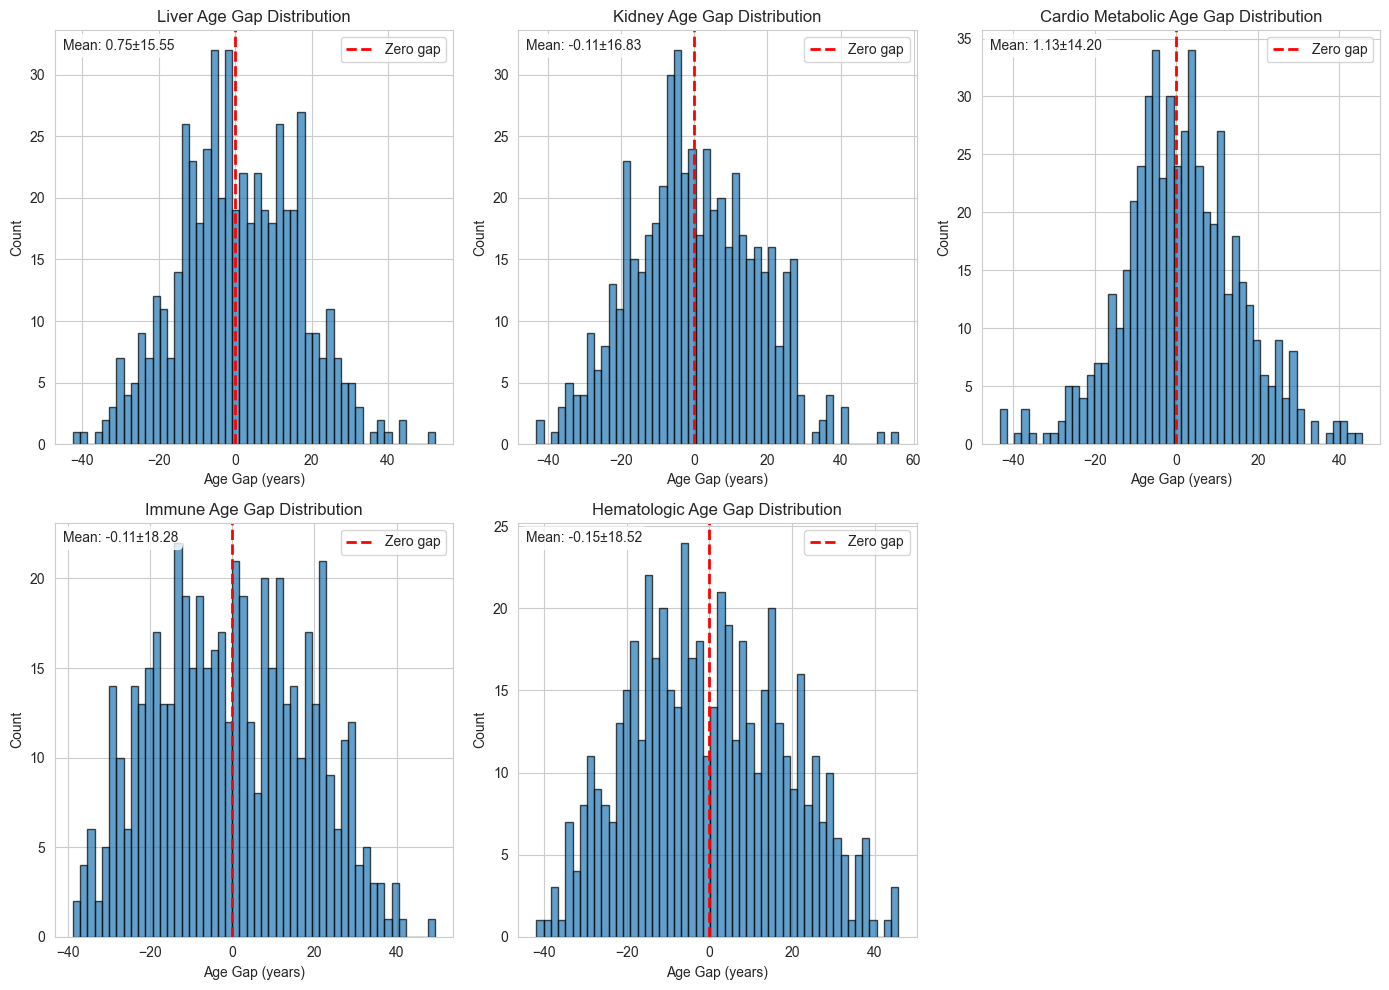


Interpretation:
  - Distributions centered near 0 indicate good calibration
  - Spread shows individual variation in aging
  - Outliers indicate extreme accelerated/decelerated aging


In [5]:
# Visualize distributions
fig = visualization.plot_age_gap_distribution(age_gaps_df, gap_columns=gap_columns, figsize=(14, 10))
plt.show()

print("\nInterpretation:")
print("  - Distributions centered near 0 indicate good calibration")
print("  - Spread shows individual variation in aging")
print("  - Outliers indicate extreme accelerated/decelerated aging")

## 5. Correlation Analysis Between Organs

Do organs age together, or independently?

ORGAN AGE GAP CORRELATIONS

Correlations between 5 organ age gaps:
                          liver_age_gap  kidney_age_gap  \
liver_age_gap                  1.000000        0.753296   
kidney_age_gap                 0.753296        1.000000   
cardio_metabolic_age_gap       0.559259        0.567695   
immune_age_gap                 0.745856        0.717545   
hematologic_age_gap            0.721345        0.672658   

                          cardio_metabolic_age_gap  immune_age_gap  \
liver_age_gap                             0.559259        0.745856   
kidney_age_gap                            0.567695        0.717545   
cardio_metabolic_age_gap                  1.000000        0.636804   
immune_age_gap                            0.636804        1.000000   
hematologic_age_gap                       0.610299        0.785804   

                          hematologic_age_gap  
liver_age_gap                        0.721345  
kidney_age_gap                       0.672658  
cardio_metabo

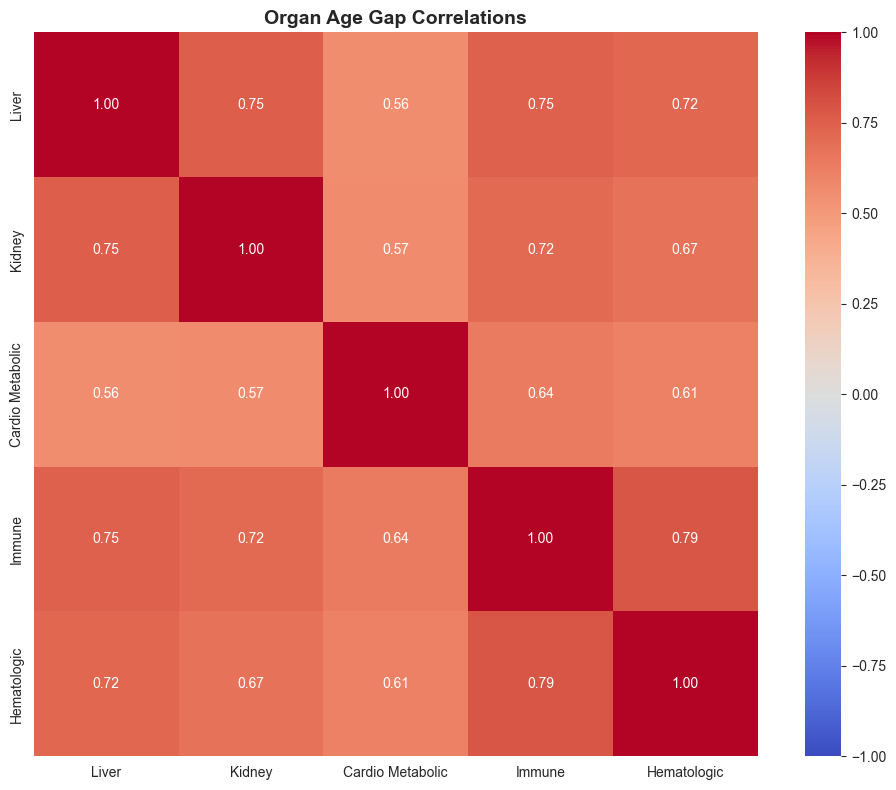


Interpretation:
  - High correlation: Organs age together (shared factors)
  - Low correlation: Independent aging patterns
  - Correlation structure reveals biological relationships


In [6]:
print("=" * 60)
print("ORGAN AGE GAP CORRELATIONS")
print("=" * 60)

# Calculate correlation matrix
corr_matrix = analysis.calculate_gap_correlations(age_gaps_df, gap_columns=gap_columns)

# Visualize
fig = visualization.plot_gap_correlation_heatmap(corr_matrix, figsize=(10, 8))
plt.show()

print("\nInterpretation:")
print("  - High correlation: Organs age together (shared factors)")
print("  - Low correlation: Independent aging patterns")
print("  - Correlation structure reveals biological relationships")

## 6. Age Gaps vs Chronological Age

Do age gaps change across the lifespan?

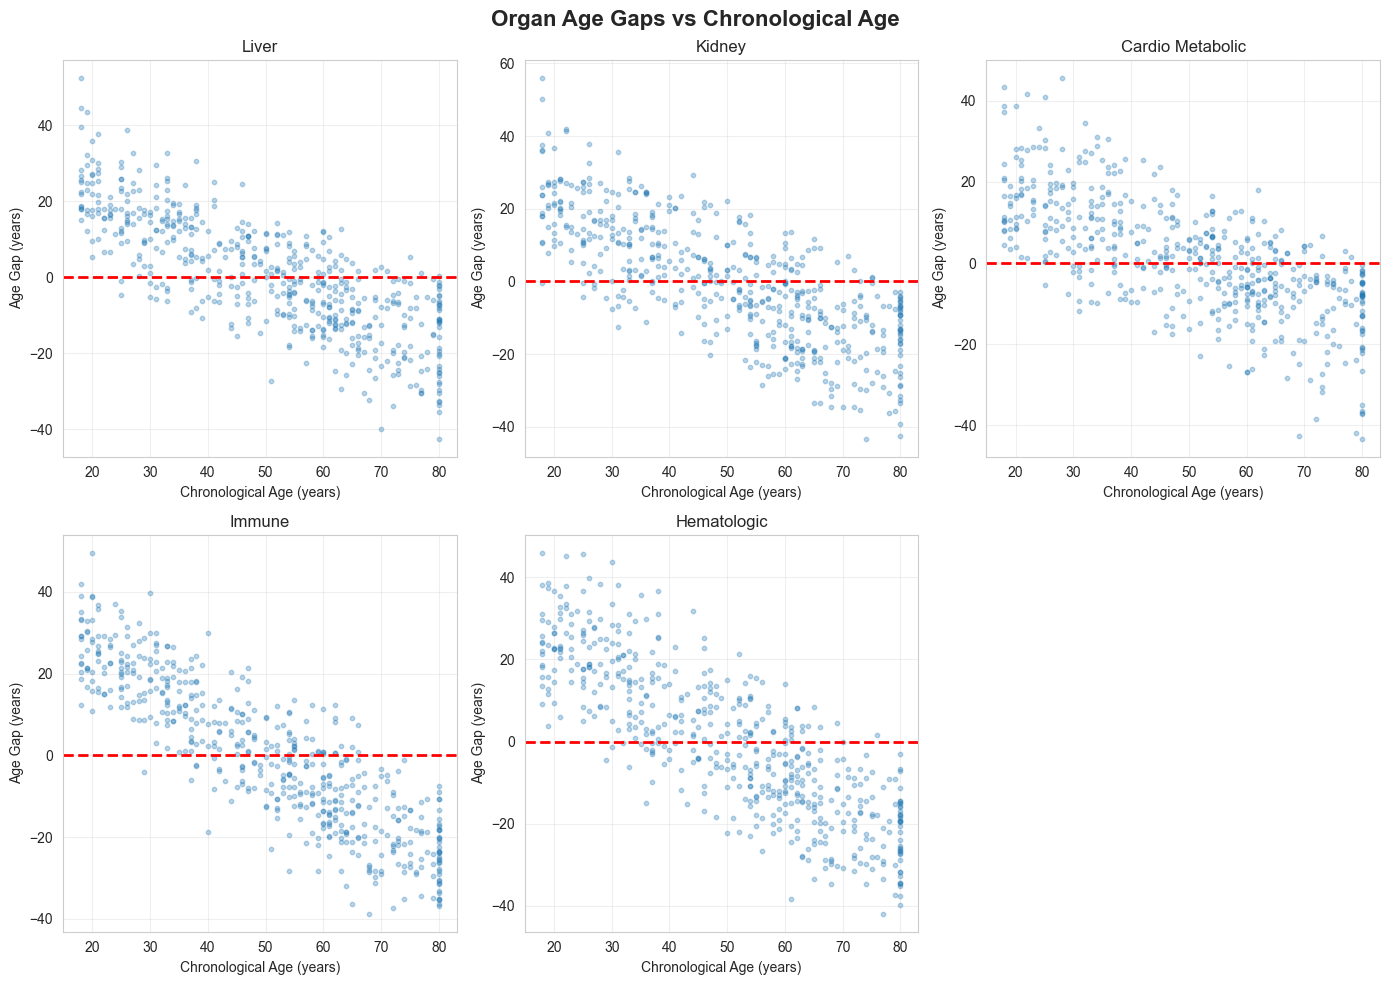


Note: Patterns reveal age-dependent changes in organ aging rates.


In [7]:
# Plot gaps vs age
fig = visualization.plot_gaps_vs_age(age_gaps_df, gap_columns=gap_columns, figsize=(14, 10))
plt.show()

print("\nNote: Patterns reveal age-dependent changes in organ aging rates.")

## 7. Identify Advanced Organs

Flag individuals with organs aging faster than expected (gap > 5 years).

In [8]:
print("=" * 60)
print("IDENTIFYING ADVANCED ORGANS (GAP > 5 YEARS)")
print("=" * 60)

age_gaps_df = analysis.identify_advanced_organs(age_gaps_df, threshold=5.0, gap_columns=gap_columns)

# Summary
advanced_cols = [col for col in age_gaps_df.columns if col.endswith('_advanced')]
print(f"\nNumber of individuals with at least one advanced organ: {(age_gaps_df[advanced_cols].sum(axis=1) > 0).sum()}")
print(f"Percentage: {100 * (age_gaps_df[advanced_cols].sum(axis=1) > 0).sum() / len(age_gaps_df):.1f}%")

IDENTIFYING ADVANCED ORGANS (GAP > 5 YEARS)
liver: 213 (40.1%) individuals with gap > 5.0 years
kidney: 203 (38.2%) individuals with gap > 5.0 years
cardio_metabolic: 195 (36.7%) individuals with gap > 5.0 years
immune: 211 (39.7%) individuals with gap > 5.0 years
hematologic: 204 (38.4%) individuals with gap > 5.0 years

Number of individuals with at least one advanced organ: 323
Percentage: 60.8%


## 8. Co-occurrence Analysis

Do certain organs tend to age together?

CO-OCCURRENCE ANALYSIS OF ADVANCED ORGANS

Co-occurrence Analysis:
  Individuals with any organ advanced: 323 (60.8%)
  Individuals with multiple organs advanced: 255 (48.0%)

Top combinations (count >= 5):
  (False, False, False, False, False): 208
  (True, True, True, True, True): 96
  (True, True, False, True, True): 22
  (False, False, True, False, False): 18
  (False, True, False, False, False): 17
  (True, False, False, False, False): 13
  (False, False, False, False, True): 12
  (True, False, True, True, True): 11
  (False, False, True, True, True): 8
  (True, False, False, False, True): 8


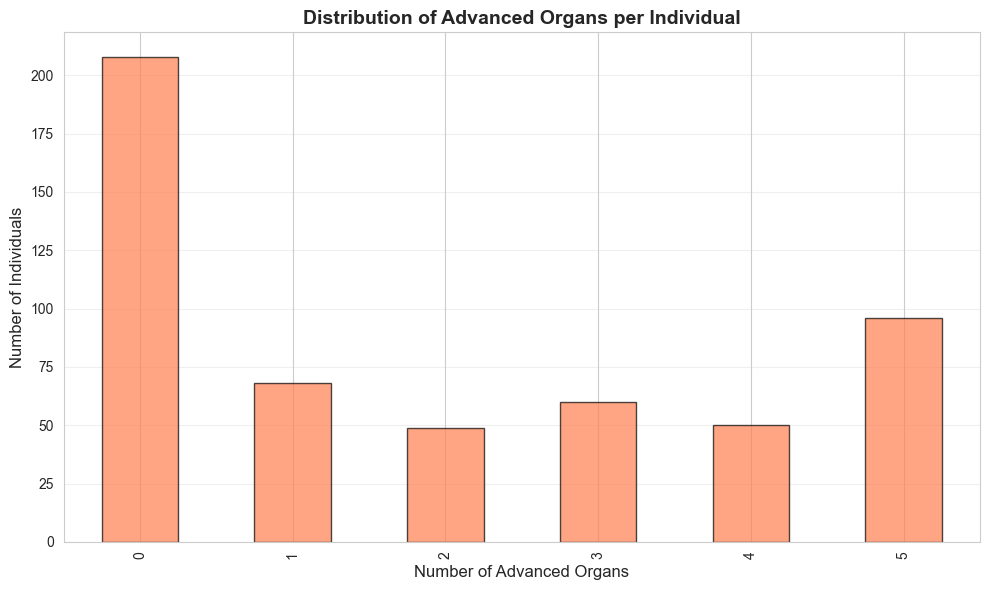


Mean advanced organs per person: 1.93
Max advanced organs in one person: 5


In [9]:
print("=" * 60)
print("CO-OCCURRENCE ANALYSIS OF ADVANCED ORGANS")
print("=" * 60)

cooccur_results = analysis.analyze_cooccurrence(age_gaps_df, organ_cols=advanced_cols, min_count=5)

# Visualize number of advanced organs per person
n_advanced = age_gaps_df[advanced_cols].sum(axis=1)

fig, ax = plt.subplots(figsize=(10, 6))
n_advanced.value_counts().sort_index().plot(kind='bar', ax=ax, color='coral', edgecolor='black', alpha=0.7)
ax.set_xlabel('Number of Advanced Organs', fontsize=12)
ax.set_ylabel('Number of Individuals', fontsize=12)
ax.set_title('Distribution of Advanced Organs per Individual', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nMean advanced organs per person: {n_advanced.mean():.2f}")
print(f"Max advanced organs in one person: {n_advanced.max():.0f}")

## 9. Analysis by Demographics

### By Age Groups

Examine how age gaps vary across different age ranges.

In [10]:
print("=" * 60)
print("AGE GAPS BY AGE GROUP")
print("=" * 60)

# Define age bins
age_bins = [18, 30, 40, 50, 60, 70, 80]

gap_by_age = analysis.analyze_gaps_by_age_group(
    age_gaps_df, 
    gap_columns=gap_columns, 
    age_col='AGE', 
    bins=age_bins
)

AGE GAPS BY AGE GROUP
Created 6 age bins
age_bin
[18, 30)     97
[30, 40)     83
[40, 50)     63
[50, 60)     89
[60, 70)    103
[70, 80)     57
Name: count, dtype: int64

Mean age gaps by age group:
         liver_age_gap                  kidney_age_gap                   \
                  mean        std count           mean        std count   
age_bin                                                                   
[18, 30)     19.531584   9.964851    97      19.339057  11.323782    97   
[30, 40)     10.679269   9.670942    83      10.020826  10.374863    83   
[40, 50)      3.345925   9.172325    63       4.019907  11.380433    63   
[50, 60)     -2.282479   8.822459    89      -4.177792  11.393354    89   
[60, 70)     -8.927937   9.574973   103     -10.847596  11.747209   103   
[70, 80)    -14.322154  10.620785    57     -15.955563  11.648885    57   

         cardio_metabolic_age_gap                  immune_age_gap             \
                             mean        std

## 10. Identify Fastest Aging Organs

Which organ shows the largest age gap for each individual?

FASTEST AGING ORGAN PER INDIVIDUAL

Fastest aging organ distribution:
fastest_aging_organ
cardio_metabolic    144
liver               107
hematologic         100
kidney               94
immune               86
Name: count, dtype: int64


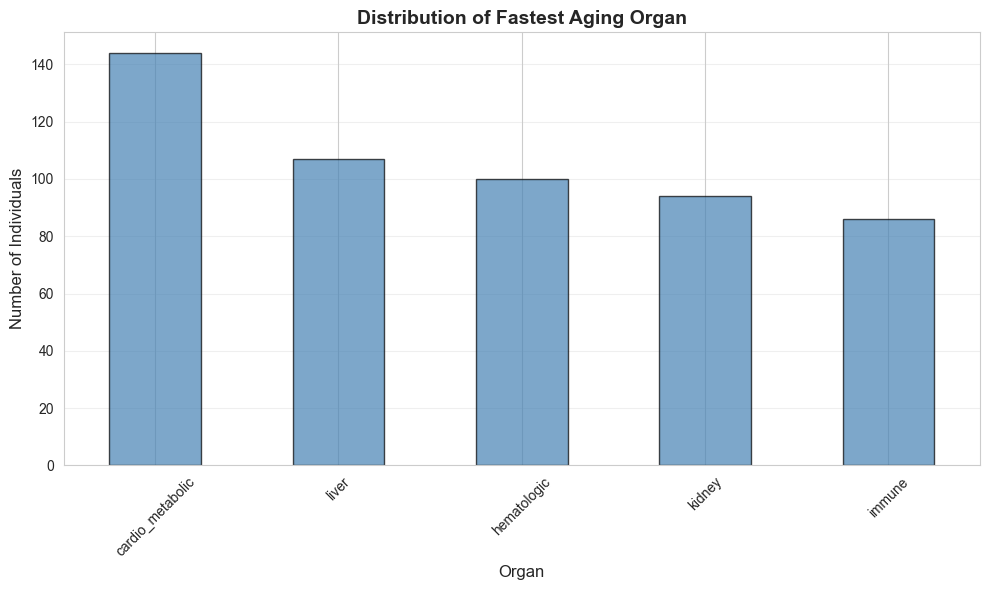

In [11]:
print("=" * 60)
print("FASTEST AGING ORGAN PER INDIVIDUAL")
print("=" * 60)

age_gaps_df = analysis.identify_fastest_aging_organs(
    age_gaps_df, 
    gap_columns=gap_columns, 
    per_individual=True
)

# Visualize distribution
fig, ax = plt.subplots(figsize=(10, 6))
fastest_counts = age_gaps_df['fastest_aging_organ'].value_counts()
fastest_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('Organ', fontsize=12)
ax.set_ylabel('Number of Individuals', fontsize=12)
ax.set_title('Distribution of Fastest Aging Organ', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Individual Aging Profiles

Visualize aging profiles for selected individuals.

In [12]:
# Select example individuals: one with high gaps, one with low gaps, one with mixed
mean_gap = age_gaps_df[gap_columns].mean(axis=1)

# Individual with highest mean gap (accelerated aging)
idx_high = mean_gap.idxmax()
# Individual with lowest mean gap (decelerated aging)
idx_low = mean_gap.idxmin()
# Individual near median (typical aging)
idx_median = mean_gap.loc[(mean_gap - mean_gap.median()).abs().argsort()[:1]].index[0]

print("=" * 60)
print("EXAMPLE INDIVIDUAL AGING PROFILES")
print("=" * 60)

for label, idx in [("Accelerated Aging", idx_high), ("Typical Aging", idx_median), ("Decelerated Aging", idx_low)]:
    print(f"\n{label}:")
    individual = age_gaps_df.loc[idx]
    print(f"  Age: {individual['AGE']:.0f} years")
    print(f"  Mean gap: {mean_gap.loc[idx]:.2f} years")
    
    # Show gaps for each organ
    print("  Organ gaps:")
    for col in gap_columns:
        organ = col.replace('_age_gap', '')
        print(f"    {organ}: {individual[col]:.2f} years")

EXAMPLE INDIVIDUAL AGING PROFILES

Accelerated Aging:
  Age: 18 years
  Mean gap: 44.63 years
  Organ gaps:
    liver: 52.37 years
    kidney: 55.87 years
    cardio_metabolic: 43.44 years
    immune: 41.95 years
    hematologic: 29.50 years

Typical Aging:
  Age: 45 years
  Mean gap: -0.26 years
  Organ gaps:
    liver: -4.98 years
    kidney: 6.77 years
    cardio_metabolic: 1.18 years
    immune: -7.69 years
    hematologic: 3.43 years

Decelerated Aging:
  Age: 80 years
  Mean gap: -31.60 years
  Organ gaps:
    liver: -35.49 years
    kidney: -39.13 years
    cardio_metabolic: -12.68 years
    immune: -33.20 years
    hematologic: -37.49 years


## 12. Organ Age Gap Variability

Which organs show the most variable aging patterns?

ORGAN AGE GAP VARIABILITY

Organ age gap variability:
              organ      mean        std        iqr          cv        min  \
4       hematologic -0.145776  18.524428  28.751522  127.075038 -41.903431   
3            immune -0.112008  18.282076  28.630566  163.221307 -38.711058   
1            kidney -0.112122  16.829237  23.881545  150.098074 -43.299441   
0             liver  0.747323  15.548486  22.491764   20.805570 -42.517762   
2  cardio_metabolic  1.126654  14.199870  17.830716   12.603575 -43.258868   

         max  
4  45.793532  
3  49.367427  
1  55.872016  
0  52.368893  
2  45.487894  


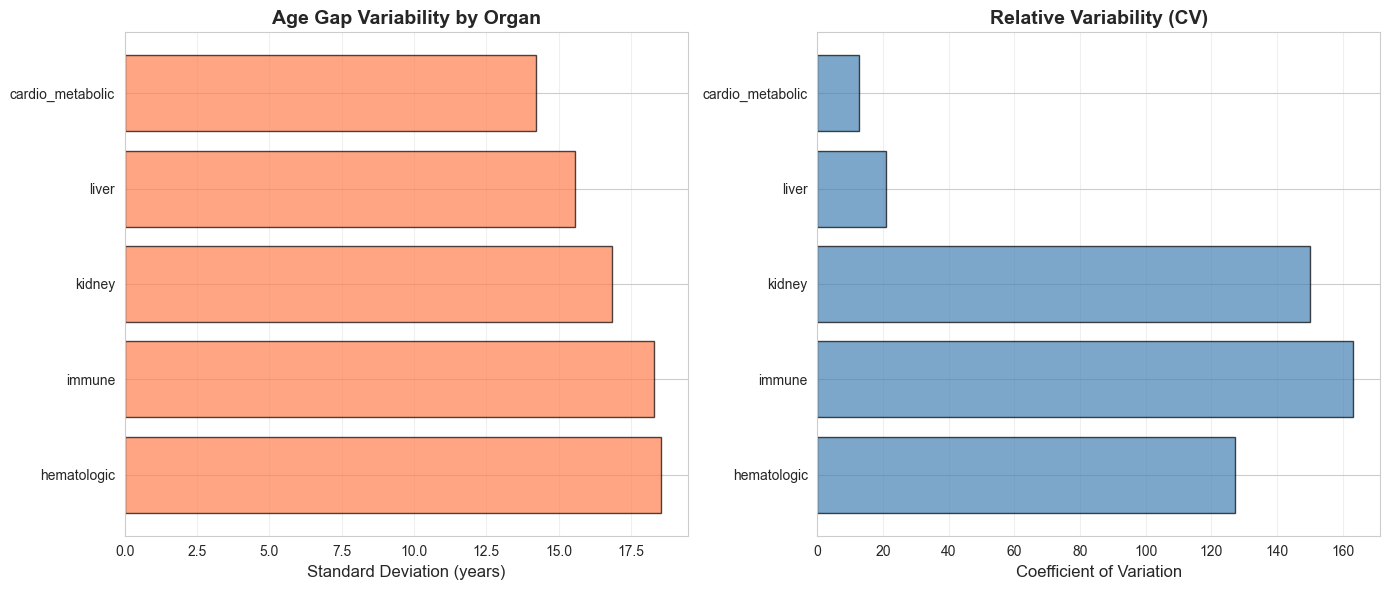


Interpretation:
  - Higher variability = more heterogeneous aging
  - Lower variability = more uniform aging
  - CV normalizes for mean differences


In [13]:
print("=" * 60)
print("ORGAN AGE GAP VARIABILITY")
print("=" * 60)

variability_df = analysis.calculate_gap_variability(age_gaps_df, gap_columns=gap_columns)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Standard deviation
axes[0].barh(variability_df['organ'], variability_df['std'], color='coral', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Standard Deviation (years)', fontsize=12)
axes[0].set_title('Age Gap Variability by Organ', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Coefficient of variation
axes[1].barh(variability_df['organ'], variability_df['cv'], color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Coefficient of Variation', fontsize=12)
axes[1].set_title('Relative Variability (CV)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  - Higher variability = more heterogeneous aging")
print("  - Lower variability = more uniform aging")
print("  - CV normalizes for mean differences")

## 13. Save Age Gap Dataset

Save comprehensive age gap dataset for further analysis.

In [14]:
# Save age gaps dataframe
output_dir = project_root / "data" / "processed"
output_path = output_dir / "age_gaps.parquet"

age_gaps_df.to_parquet(output_path, index=True)

print("✓ Age gap dataset saved")
print(f"  Path: {output_path}")
print(f"  Shape: {age_gaps_df.shape}")
print(f"  Columns: {age_gaps_df.shape[1]}")
print(f"\nColumn types:")
print(f"  - Chronological age: 1")
print(f"  - Biological ages: {len([col for col in age_gaps_df.columns if col.endswith('_age_bio')])}")
print(f"  - Age gaps: {len(gap_columns)}")
print(f"  - Advanced flags: {len(advanced_cols)}")
print(f"  - Fastest aging: 2")

✓ Age gap dataset saved
  Path: C:\Users\bastien\Documents\TAF\Hackathon\Vitalist\data\processed\age_gaps.parquet
  Shape: (531, 18)
  Columns: 18

Column types:
  - Chronological age: 1
  - Biological ages: 5
  - Age gaps: 5
  - Advanced flags: 5
  - Fastest aging: 2


## 14. Summary and Next Steps

### What We Accomplished

✓ Loaded trained organ clock models
✓ Computed biological ages for all organs
✓ Calculated age gaps (biological - chronological)
✓ Analyzed age gap distributions
✓ Examined correlations between organ gaps
✓ Stratified analysis by age groups
✓ Identified individuals with advanced organs
✓ Analyzed co-occurrence patterns
✓ Examined individual aging profiles
✓ Saved comprehensive age gap dataset

### Key Findings

- **Age gap distributions** show substantial individual variation
- **Organ correlations** reveal both shared and independent aging processes
- **Advanced organs** (gap > 5 years) are present in X% of individuals
- **Co-occurrence patterns** suggest coordinated aging of certain organ systems
- **Individual profiles** demonstrate heterogeneous multi-organ aging patterns

### Clinical Implications

1. **Risk stratification**: Identify individuals with accelerated organ aging
2. **Targeted screening**: Focus on organs showing largest gaps
3. **Intervention opportunities**: Address modifiable risk factors
4. **Personalized prevention**: Tailor health strategies to individual profiles

### Next Notebook: Trajectories and Clustering

In `05_trajectories_and_clustering.ipynb`, we will:
1. Perform pseudo-longitudinal trajectory analysis
2. Apply dimensionality reduction (PCA, UMAP)
3. Cluster individuals by aging patterns
4. Identify aging subtypes/phenotypes
5. Analyze cluster characteristics
6. Visualize aging trajectories

---

**TDD Note**: All analysis functions are tested in `tests/test_analysis.py` and `tests/test_evaluation.py`